In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
import librosa, librosa.display
from tensorflow import keras

# Load Dataset

In [ ]:
# load all data for 17 drivers
DATA_PATH = 'drive/MyDrive/ecg_data/'
FILE_NAMES = ['drive01.txt', 'drive02.txt', 'drive03.txt', 'drive04.txt', 'drive05.txt', 'drive06.txt', 'drive07.txt', 
              'drive08.txt', 'drive09.txt', 'drive10.txt', 'drive11.txt', 'drive12.txt', 'drive13.txt', 'drive14.txt',
             'drive15.txt', 'drive16.txt', 'drive17a.txt', 'drive17b.txt']

SELECT_COLS = ['Elapsed_time', 'ECG', 'foot_GSR']

all_drivers_data = []

for file in FILE_NAMES:
    df = pd.read_csv(DATA_PATH+file, sep="\t")
    df = df.iloc[1:, :]
    df = df[['   Elapsed time', '    ECG', 'oot GSR']]
    df.columns = SELECT_COLS
    
    df['Elapsed_time'] = df['Elapsed_time'].astype('float')
    df['ECG'] = df['ECG'].astype('float')
    df['foot_GSR'] = df['foot_GSR'].astype('float')
    
    all_drivers_data.append(df)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocessing

In [ ]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter


# A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a


# A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a


def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a


def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z

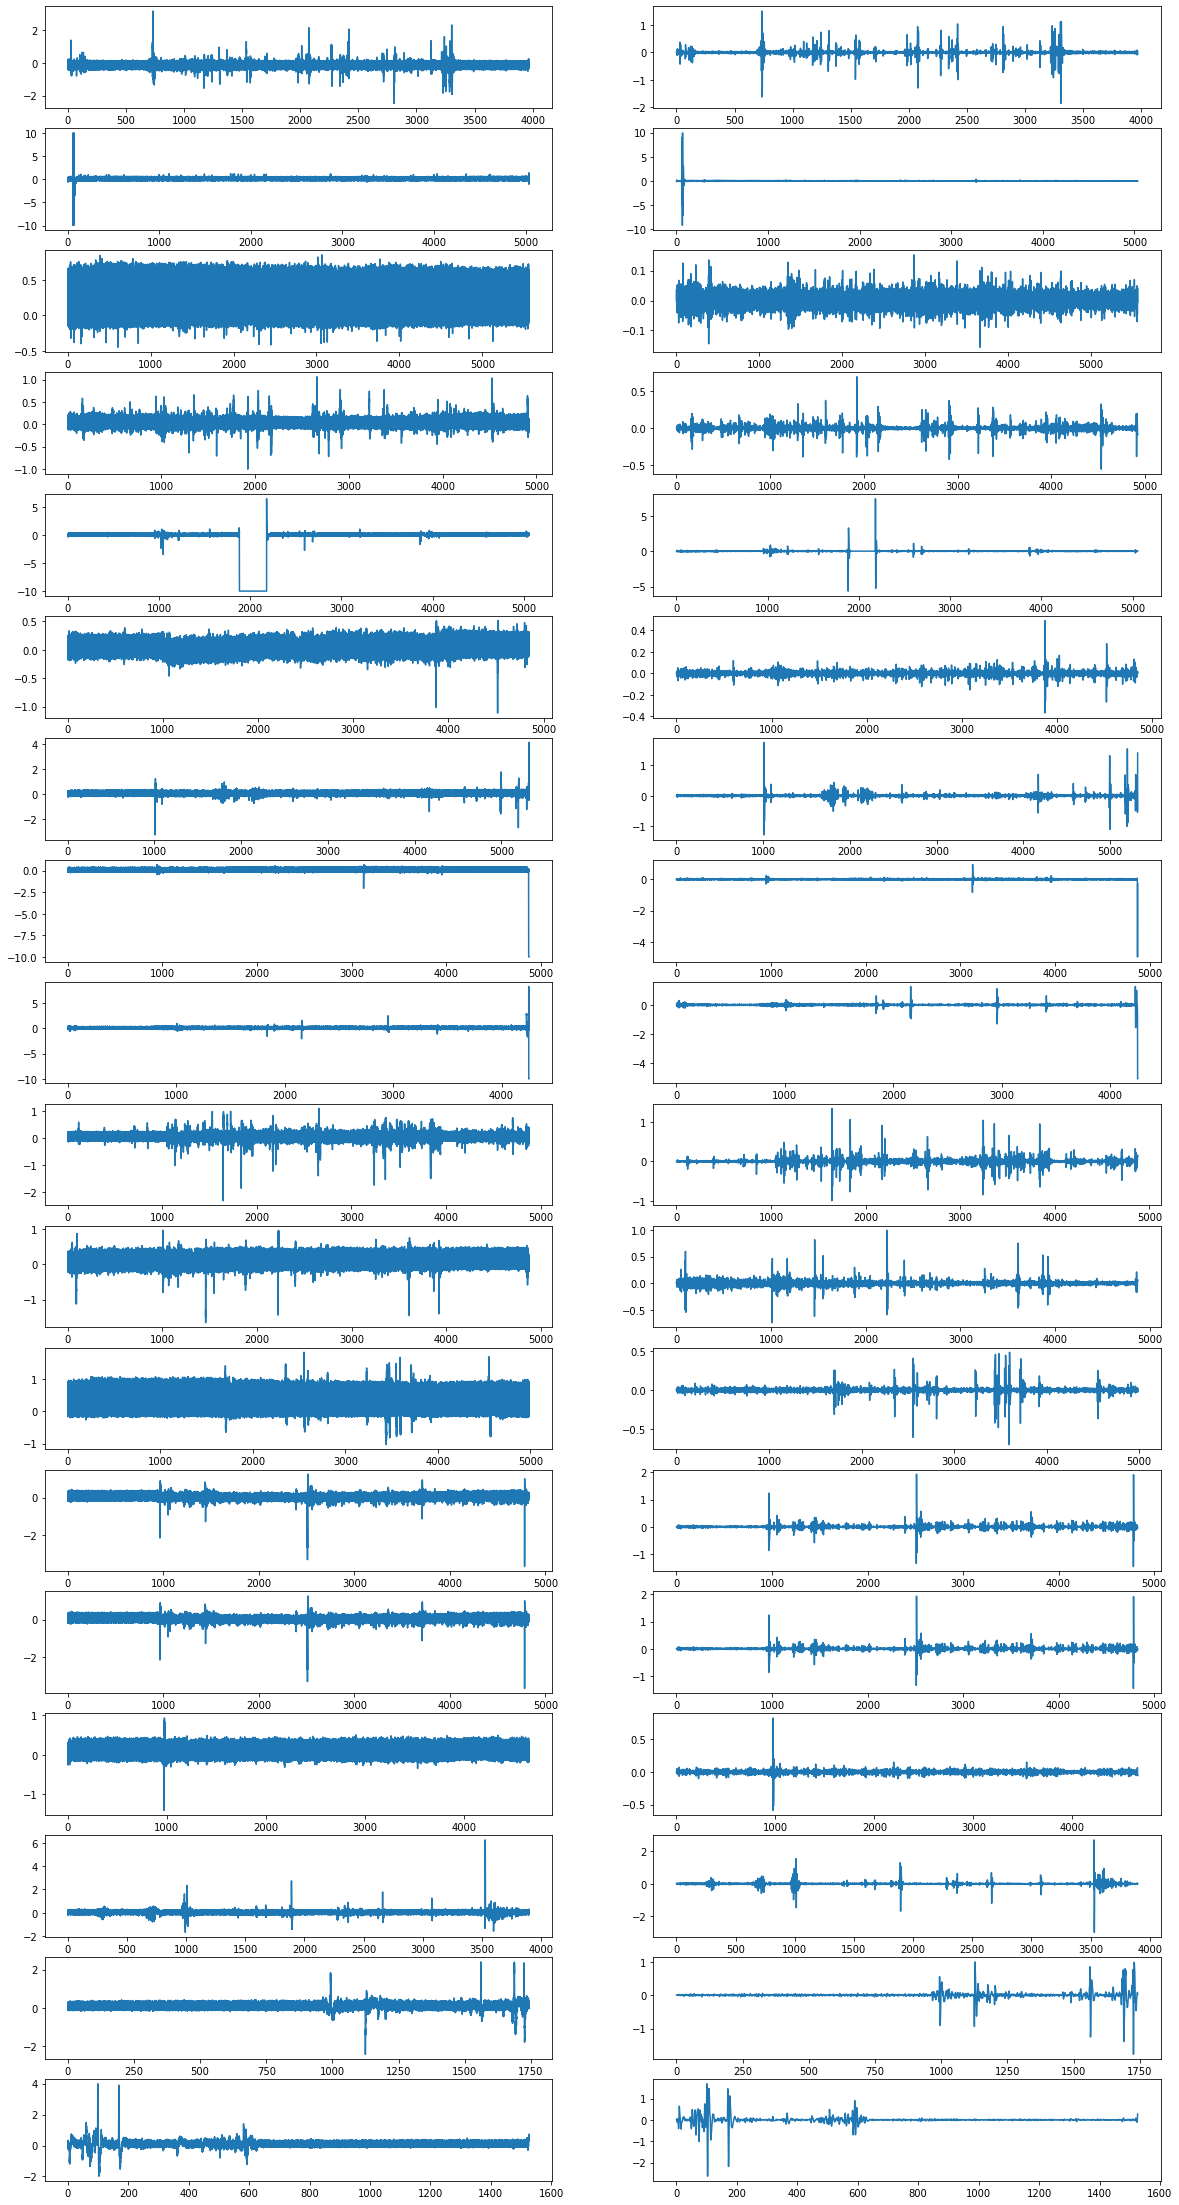

In [ ]:
fs = 120

# Order of five works well with ECG signals
cutoff_high = 0.5
cutoff_low = 2.5
powerline = 60
order = 3

# Plot graph showing Raw ECG signal vs Clean ECG signal.
fig, ax = plt.subplots(18, 2, figsize=(20, 40))


for i, df in enumerate(all_drivers_data):
    df['cleaned_ECG'] = final_filter(df['ECG'], fs, order)
    ax[i, 0].plot(df['Elapsed_time'], df['ECG'])
    ax[i, 1].plot(df['Elapsed_time'], df['cleaned_ECG'])

# Label Dataset as Stress or Not Stress Using Foot GSR

In [ ]:
#To assess if the driver was stressed or not stressed, 
#the median of the GSR values is takenas the cut-off point,
#and any value above the median value is labelled as stress,
#and any value below the median value is labelled as not stressed. 

def fix_stress_labels(df):
    foot_GSR_med = df['foot_GSR'].median()
    df['stress'] = np.where(df['foot_GSR']>=foot_GSR_med, 1, 0)
    return df

for i, df in enumerate(all_drivers_data):
    all_drivers_data[i] = fix_stress_labels(all_drivers_data[i])

# Segments Signals

In [ ]:
# slice all signals into 60s per signal (930 samples per signal)
X_data = []
y_data = []

for df in all_drivers_data: 
    for j in range(df.shape[0]):
        start = 0 + (930 * j)
        end = start + 930
        data = df[start:end] 
        
        # only use data with 930 samples
        if data.shape[0] == 930:
            X_data.append(data.iloc[:, 3].T) # select only cleaned ECG signals
            
            # if more than 465 samples are labelled as stress, considered whole signal as stress
            if data[data['stress'] == 1]['stress'].count() > 465:
                y_data.append(1)
            else: 
                y_data.append(0)

In [ ]:
stress = [0, 0]

for i in y_data:
    if i == 0:
        stress[0] = stress[0] + 1
    else:
        stress[1] = stress[1] + 1

print(stress)

[695, 723]


# Feature Extraction

In [ ]:
# STFT -> spectrogram
hop_length = 128 
n_fft = 9300 
X_data2 = []

for s in X_data:
    s = np.array(s)
    
    MFCCs = librosa.feature.mfcc(s, 15.5, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)

    X_data2.append(MFCCs)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=9300 is too small for input signal of length=930
  n_fft, y.shape[-1]


Text(0.5, 1.0, 'MFCCs')

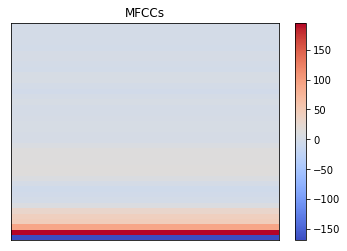

In [ ]:
plt.figure()
librosa.display.specshow(MFCCs, sr=15.5, hop_length=hop_length)
plt.colorbar()
plt.title("MFCCs")

# Split Dataset into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data, train_size=0.75, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 2))
y_test = np.array(keras.utils.to_categorical(y_test, 2))

X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1063, 40, 8)
(1063, 2)
(355, 40, 8)
(355, 2)


# Training Using KFold

In [ ]:
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from keras import regularizers

In [ ]:
%%time
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(X_train, y_train):
  
    model = Sequential()

    model.add(Conv1D(filters=15, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizers.l2(0.002), input_shape=(40, 8)))
    model.add(Conv1D(filters=20, kernel_size=5, strides=1, padding="same", kernel_regularizer=regularizers.l2(0.002)))
    model.add(Conv1D(filters=30, kernel_size=10, strides=1, padding="same", kernel_regularizer=regularizers.l2(0.002)))
    model.add(Conv1D(filters=50, kernel_size=20, strides=1, padding="same", kernel_regularizer=regularizers.l2(0.002)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Flatten())

    #Neural Network with Dropout
    model.add(Dense(units=20, activation="relu"))
    model.add(Dropout(rate=0.4))
    model.add(Dense(units=2, activation="softmax"))
    
    model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['acc'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train[train], y_train[train],
                      batch_size=32,
                      epochs=100,
                      verbose=1)
  
    # Generate generalization metrics
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
30/30 [==============================] - 1s 9ms/step - loss: 0.9243 - acc: 0.5045
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8639 - acc: 0.5260
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8493 - acc: 0.5357
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8315 - acc: 0.5674
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8057 - acc: 0.5864
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.7907 - acc: 0.5709
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8032 - acc: 0.5877
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.7726 - acc: 0.5797
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.7597 - acc: 0.5867
Epoch 10/100
30/30 [==============================] - 0s 

In [ ]:
print(acc_per_fold)
print(loss_per_fold)

[74.76635575294495, 64.4859790802002, 63.55140209197998, 72.64150977134705, 64.15094137191772, 61.320751905441284, 69.8113203048706, 61.320751905441284, 61.320751905441284, 67.92452931404114]
[0.6090644001960754, 0.6752658486366272, 0.6312316656112671, 0.6613178849220276, 0.8250817060470581, 0.7472418546676636, 0.6192089319229126, 0.6725260019302368, 0.664059042930603, 0.6595982313156128]


# Model Evaluation

In [ ]:
from keras.models import load_model

# Keras reported accuracy:
score = model.evaluate(X_test, y_test, verbose=1) 
print ("model train data score       : ", score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.6136 - acc: 0.7239
model train data score       :  0.7239436507225037


In [ ]:
model.save('drive/MyDrive/ecg72.4%.hdf5')